# Тематическое моделирование на данных Вконтакте: использование модели LDA, визуализация топиков, построение тематических профилей.
# Цель
Боевой проект по тематическому моделированию. Цель - построить LDA модель и получить интерпретируемые топики. Попробовать посчитать тематические профили и получить их визуализацию на двумерной плоскости при помощи TSNE
В материалах вы можете найти выгрузку комментариев из разных музыкальных групп ВК, в полях music_style и performer можно получить информацию о конкретном музыкальном жанре и исполнителе, в группе которого был написан комментарий. Выгрузка уменьшенная, остались только комментарии длиной больше 40 слов, но тем не менее это всё ещё 500Мб, так что модельки будут считаться долго. Для отладки рекомендую брать небольшую выборку из этого датасета, чтобы на ней тестировать свой код.

Если у вас есть собственный датасет - можно использовать его :)

1. Загрузите датасет. Если используете данные вк, то после загрузки воспользуйтесь следующим кодом:
```python
from ast import literal_eval
bag_of_words = data.text_bow.apply(literal_eval)
```
где data - это загруженный датасет. Операция необходима, так как предварительно уже была проведена предобработка текстов и получено представление bag-of-words, так что остаётся его лишь прочитать из датасета

2. Используя gensim, добавьте биграммы к имеющемуся bag_of_words представлению

3. Составьте словарь из терминов (corpora.Dictionary)

4. По словарю терминов при помощи метода filter_extremes проведите фильтрацию слов по частоте встречаемости. На данных вк рекомендую следующие параметры: (no_below=3, no_above=0.4, keep_n=3*10**6)

5. Наконец, составьте итоговый корпус документов при помощи метода doc2bow. Рекомендую его сохранить (например, в pickle формате), на случай, если что-то где-то пойдет не так

6. По получившемуся корпусу постройте LDA модель, если используете данные вк, рекомендую параметры (eval_every=20, num_topics=30, passes=5). Не забудьте сохранить саму модель и её аттрибут expElogBeta, также при помощи метода show_topics возьмите по 100 самых вероятных слов для каждой темы

7. При помощи wordcloud визуализируйте каждый из получившихся топиков и попробуйте их проинтерпретировать. Чтобы не возиться долго с функциями для визуализации, можно взять их отсюда - https://github.com/DmitrySerg/top-russian-music/blob/master/models/clean_visualization.ipynb

8. Наконец, постройте тематические профили по интересующим вас группировкам (в случае с вк можно построить средние тематические вектора по жанрам или по исполнителям, если у вас собственные данные, попробуйте подумать, как можно было бы сгруппировать ваши документы, чтобы все-таки построить профили групп), и визуализируйте их при помощи TSNE

9. Вы великолепны
Критерии оценки: Получилось построить LDA и хотя бы в текстовом формате показать наиболее характерные для каждого топика слова - 5 баллов

Есть визуализация wordcloud +2 балла

Есть визуализация TSNE для тематических профилей +3 балла

In [2]:
import re
import pickle
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# nltk.download('wordnet')
# nltk.download('stopwords')
lemma = WordNetLemmatizer()

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# EDA

# 1. Анализ данных

Считаем дата-сет из файла и выведем несколько строк.

In [3]:
df = pd.read_csv('data/reduced_comments_vk.csv')
print(df.shape)
df.head(4)

(105377, 16)


Unnamed: 0 audio     author              comment_id                 date  \
0           9   NaN  146608415  52228413_282387_282503  2019-01-01 17:43:48   
1         103   NaN  197130573  52228413_282259_282287  2018-12-31 13:47:29   
2         107   NaN  -52228413  52228413_282158_282162  2018-12-30 21:04:56   
3         130   NaN  197130573  52228413_282158_282211  2018-12-30 23:04:28   

                                          dirty_text  \
0  [id415608045|Иван],\nВ который раз, весь мир л...   
1  С Наступающим!. Пусть старый год уходя оставит...   
2  Автор музыки и слов - Дмитрий Митькин.\n\nВ ко...   
3  Ура!!!🔥🔥🔥🔥🔥🔥🔥🔥 Предновогодняя премьера от непо...   

                                 emoji  likes link music_style performer  \
0                                  NaN      1  NaN     estrada      лепс   
1                                  NaN      2  NaN     estrada      лепс   
2                                  NaN     29  NaN     estrada      лепс   
3  🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥👍👍👍👍👍👍👍👍💪💪💪💪💪💪💪💪🔥🔥😎😎😎      6  NaN     estrada      лепс   

   stickers                                               text video  \
0       NaN  id415608045 иван который весь мир лететь чужое...   NaN   
1       NaN  наступать пусть старый год уходить оставить ве...   NaN   
2       NaN  автор музыка слово дмитрий митькина который ве...   NaN   
3       NaN  ура предновогодний премьера неподражаемый непр...   NaN   

                                            text_bow  comment_len  
0  ['id415608045', 'иван', 'который', 'весь', 'ми...         79.0  
1  ['наступать', 'пусть', 'старый', 'год', 'уходи...         42.0  
2  ['автор', 'музыка', 'слово', 'дмитрий', 'митьк...         82.0  
3  ['ура', 'предновогодний', 'премьера', 'неподра...         43.0

Датасет содержит 16 признаков и 105377 строк. Нас интересует поле `text_bow`, в котором подготовлены слова.

Проверим это поле на нулевые значения

In [4]:
null_in_text_bow = df['text_bow'].isnull().sum()
print('Кол-во нулевых значений в `text_bow`:', null_in_text_bow)

Кол-во нулевых значений в `text_bow`: 0


# 2. Предварительное моделирование

In [5]:
df_train = df.text_bow.sample(frac=0.05)

Импортируем коментарии в `мешок слов`

In [6]:
from ast import literal_eval
bag_of_words = df_train.apply(literal_eval)

Создадим переменную-флаг, что при повторном запуске не проводить обработку заново, а считывать из схраненного файла.

In [17]:
prepare = True

Построим биграмы.

In [8]:
if prepare:
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(bag_of_words, min_count=5, threshold=100) # higher threshold fewer phrases.

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    bigram_mod.save('bigram_mod.pkl')
    
    data_words_bigrams = [bigram_mod[w] for w in bag_of_words]
    with open('bigrams.pkl', 'wb') as f:
        pickle.dump(data_words_bigrams, f)

else:
    bigram_mod = gensim.models.Phrases.load('bigram_mod.pkl')
    
    with open('bigrams.pkl', 'rb') as f:
        data_words_bigrams = pickle.load(f)

Создадим словарь с биграмами.

In [9]:
if prepare:
    id2word = corpora.Dictionary(data_words_bigrams)
    id2word.save('id2word.pkl')
else:
    id2word = corpora.Dictionary.load('id2word.pkl')

In [10]:
id2word.filter_extremes(no_below=3, no_above=0.4, keep_n=3*10**6)

Создадим корпус слов.

In [11]:
corpus = [id2word.doc2bow(text) for text in data_words_bigrams]

In [12]:
corpus[0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 11),
 (6, 4),
 (7, 1),
 (8, 1),
 (9, 1)]

Ниже опишем функцию для подсчета когерентности и определения оптимального количества топиков.

In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Посчитаем значения когерентности и отпобразим их графически.

In [14]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=40, step=3)

CPU times: user 7min 44s, sys: 7.86 s, total: 7min 51s
Wall time: 9min 24s


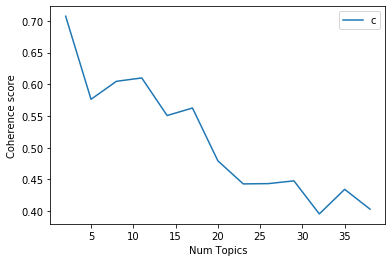

In [16]:
limit=40; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Как видно из графика, наиболее оптимальное количество топиков в диапазоне от 10 до 13. Количество топиков 2 с наибольшим значением когерентности не берем в расчет, так как априори ясно, что топиков больше двух.

Выведем списком расчитанные значения.

In [32]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7073
Num Topics = 5  has Coherence Value of 0.5764
Num Topics = 8  has Coherence Value of 0.6047
Num Topics = 11  has Coherence Value of 0.61
Num Topics = 14  has Coherence Value of 0.5508
Num Topics = 17  has Coherence Value of 0.5626
Num Topics = 20  has Coherence Value of 0.4795
Num Topics = 23  has Coherence Value of 0.443
Num Topics = 26  has Coherence Value of 0.4435
Num Topics = 29  has Coherence Value of 0.4479
Num Topics = 32  has Coherence Value of 0.3957
Num Topics = 35  has Coherence Value of 0.4345
Num Topics = 38  has Coherence Value of 0.4032


Исходя из списка за оптимальное количество топиков примнимаем значение 11.

Теперь повторим операции на все выборке данных.

# 3. Моделирование

In [22]:
bag_of_words = df.text_bow.apply(literal_eval)

In [23]:
%%time

""" Создаем биграмы """
if prepare:
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(bag_of_words, min_count=5, threshold=100) # higher threshold fewer phrases.

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    bigram_mod.save('full_bigram_mod.pkl')
    
    data_words_bigrams = [bigram_mod[w] for w in bag_of_words]
    with open('full_bigrams.pkl', 'wb') as f:
        pickle.dump(data_words_bigrams, f)

else:
    bigram_mod = gensim.models.Phrases.load('full_bigram_mod.pkl')
    
    with open('full_bigrams.pkl', 'rb') as f:
        data_words_bigrams = pickle.load(f)
        
""" Создаем словарь """
if prepare:
    id2word = corpora.Dictionary(data_words_bigrams)
    id2word.save('id2word.pkl')
else:
    id2word = corpora.Dictionary.load('id2word.pkl')
    
id2word.filter_extremes(no_below=3, no_above=0.4, keep_n=3*10**6)

""" Создаем корпус """
corpus = [id2word.doc2bow(text) for text in data_words_bigrams]

CPU times: user 1min 47s, sys: 2.74 s, total: 1min 50s
Wall time: 1min 52s


Обучим LDA-модель по подготовленным данным.

In [42]:
%%time
if prepare:
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=11, 
        random_state=100,
        update_every=1,
        eval_every=20,
        chunksize=100,
        passes=20,
        alpha='auto',
        per_word_topics=True)
    lda_model.save('full_lda_11topics.pkl')
else:
    lda_model = gensim.models.ldamodel.LdaModel.load('full_lda_default.pkl')

CPU times: user 39min 21s, sys: 43 s, total: 40min 4s
Wall time: 43min 30s


# 5. Результаты

Посмотрим какие топики получились.

In [43]:
pprint(lda_model.print_topics())

[(0,
  '0.022*"человек" + 0.021*"который" + 0.019*"весь" + 0.019*"свой" + '
  '0.016*"такой" + 0.014*"один" + 0.014*"просто" + 0.013*"очень" + '
  '0.011*"концерт" + 0.010*"хотеть"'),
 (1,
  '0.020*"клип" + 0.014*"нормальный" + 0.013*"клуб" + 0.012*"пост" + '
  '0.011*"идея" + 0.010*"путин" + 0.007*"парень" + 0.007*"организатор" + '
  '0.007*"видимо" + 0.007*"попасть"'),
 (2,
  '0.107*"наш" + 0.054*"жить" + 0.047*"играть" + 0.016*"реально" + '
  '0.014*"лиза" + 0.013*"язык" + 0.013*"позиция" + 0.012*"мы" + 0.012*"нести" '
  '+ 0.012*"знаешь"'),
 (3,
  '0.052*"твой" + 0.040*"ты" + 0.018*"мы" + 0.017*"день" + 0.015*"мир" + '
  '0.013*"любовь" + 0.012*"рука" + 0.012*"бог" + 0.011*"дом" + 0.011*"глаз"'),
 (4,
  '0.032*"http" + 0.028*"хуй" + 0.021*"закон" + 0.020*"девочка" + 0.017*"сук" '
  '+ 0.016*"кричать" + 0.016*"вести" + 0.016*"уфа" + 0.016*"мать" + '
  '0.013*"покупать"'),
 (5,
  '0.192*"фейскрыса" + 0.039*"ответить" + 0.033*"андрей" + 0.030*"участник" + '
  '0.028*"становиться" + 0.

Ниже опишем функцию для построения облаков слов для топиков.

In [44]:
from wordcloud import WordCloud 

def plotWordCloud(topic_number):
    """
        Строит визуализацию слов на основе текстов топиков
    """
    # получаем частоты и слова топика
    
#     text = dict(lda_model[topic_number][1])
    text = dict(lda_model.show_topic(topic_number,100))
    
    # строим облако слов
    wordcloud = WordCloud(background_color="white", max_words=100, width=900, height=900, collocations=False)
    wordcloud = wordcloud.generate_from_frequencies(text)
    plt.figure(figsize=(15, 10))
    plt.title("Топик номер {}".format(topic_number))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off");

Выведем облака слов.

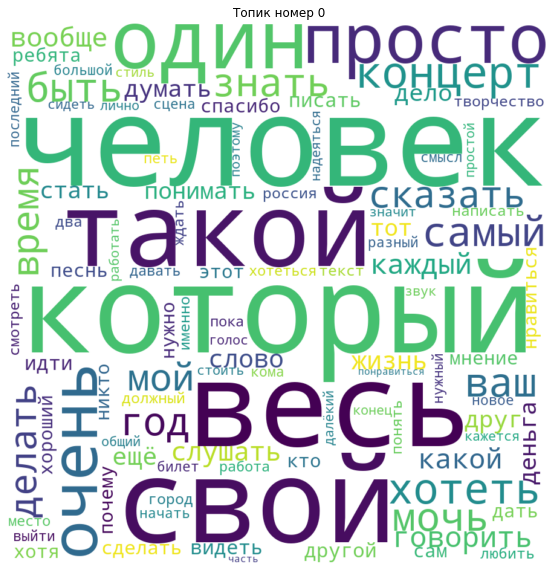

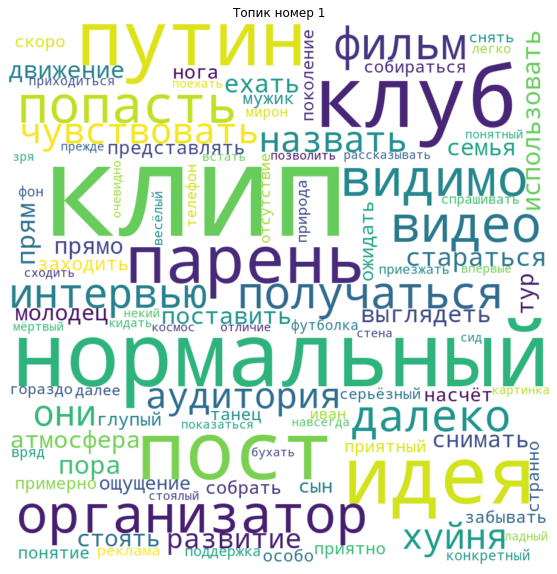

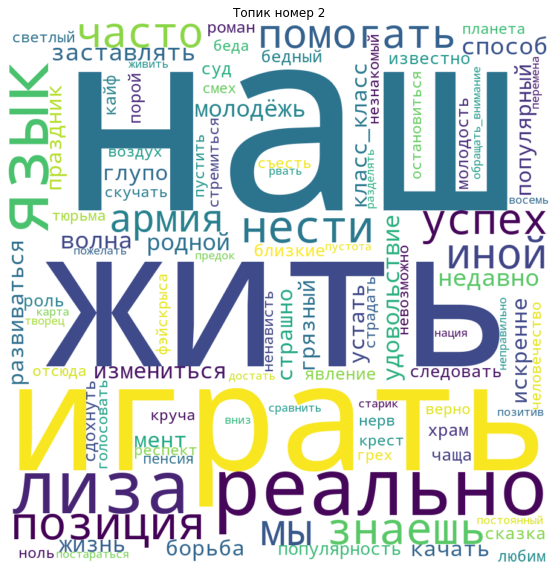

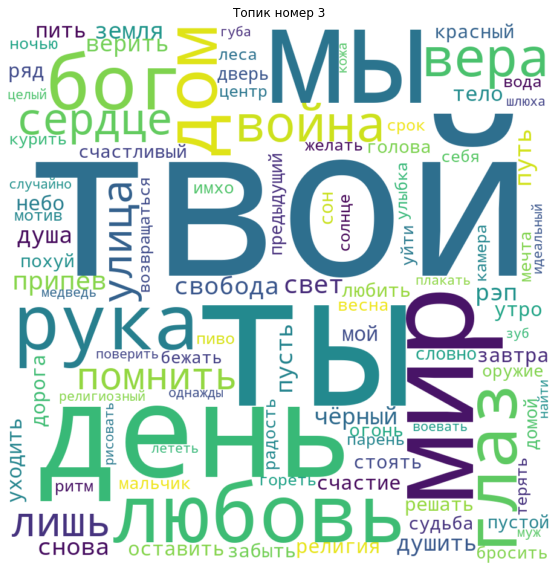

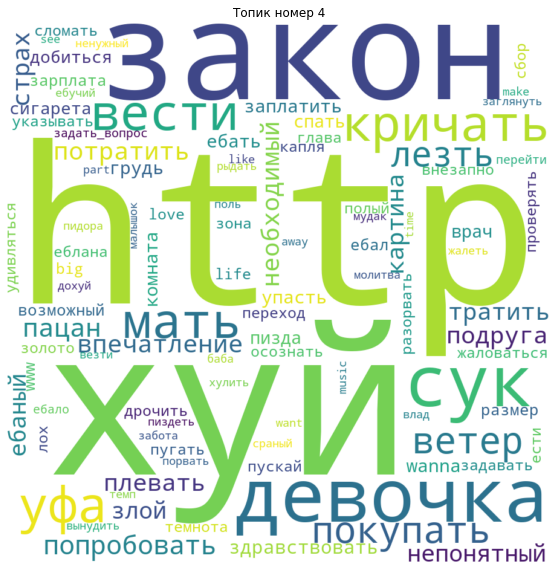

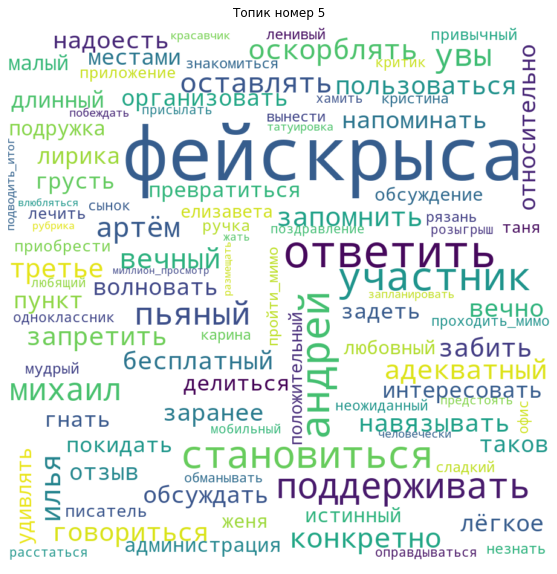

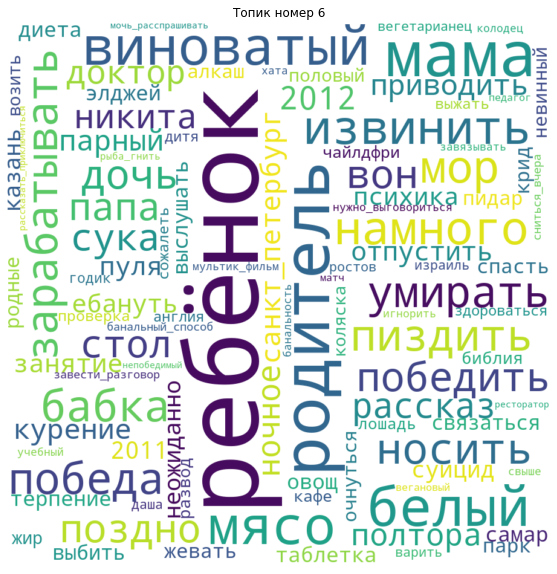

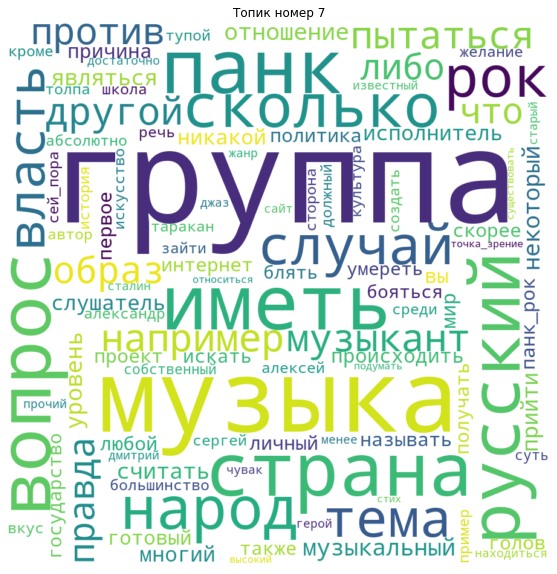

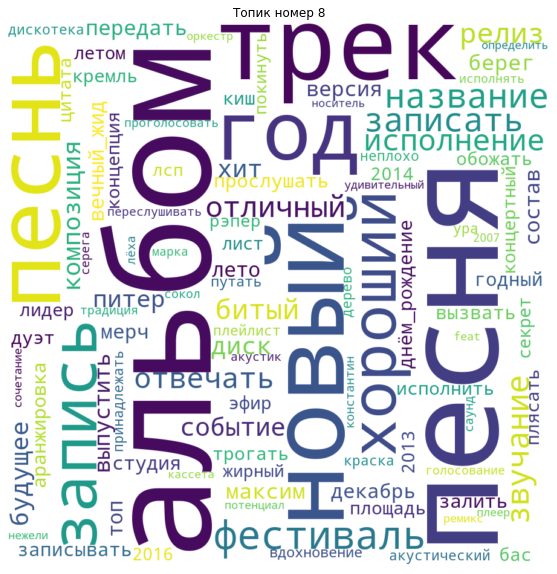

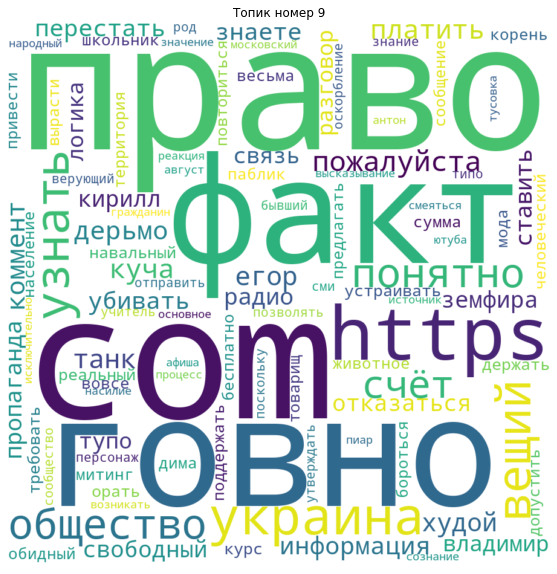

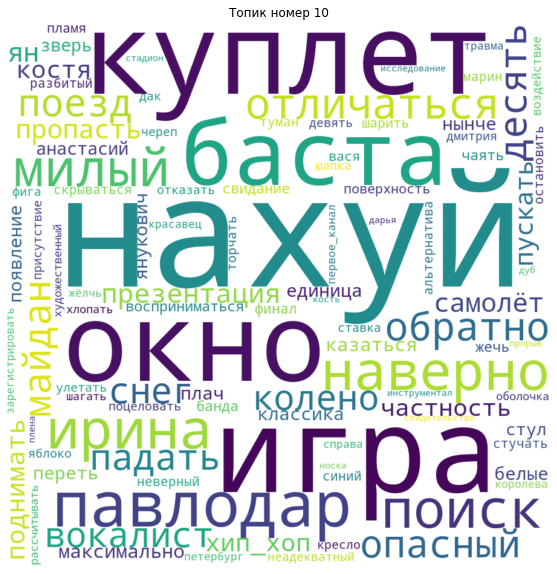

In [46]:
for i in range(11):
    plotWordCloud(topic_number=i)

Визуализируем полученные результаты при помощи T_SNE.

Опишем названия тем.

In [54]:
themes_30 = {
    0 : 'Хороший человек',         
    1 : 'Политический клип', 
    2 : 'Наша жизнь',
    3 : 'Человек и любовь',
    4 : 'Закон и оскорбления',
    5 : 'Оскорбления',          
    6 : 'Ребенок',
    7 : 'Музыкальные группы',
    8 : 'Песни и альбомы',
    9 : 'Политика',       
    10: 'Неинтерпретируемая',            
}

Построим вектора по жанрам.

In [55]:
def topicProfileGenre(model, music_style, dataset, corpus, genre=True):

    # Тут будем хранить результат
    theme_results = [ ]

    # Какое в модели количество топиков
    r = model.num_topics
    
    # Выбираем из таблицы те строки, которые соовтетствуют текущему жанру
    if genre:
        num = dataset[dataset.music_style == music_style].index.get_values() 
    else:
        num = dataset[dataset.performer == music_style].index.get_values() 

    # Вектор для тематического профиля жанра
    theme_profile = np.zeros(r)
    err = 0 # Для записи ошибок

    # Пробежимся по всем любителям текущего жанра
    for i in num:
        try:
            # вытаскиваем тематический профиль текущего юзера
            cur_user_prof = model.get_document_topics(corpus[i])

            # сортируем по номерам тем
            cur_user_prof = sorted(cur_user_prof, key=lambda w: w[0], reverse=True)      

            ind = [cup[0] for cup in cur_user_prof]     # делаем вектор с номерами тем
            prob = np.array([cup[1] for cup in cur_user_prof]) # делаем вектор с весами  
            theme_profile[ind] += prob        # Увеличиваем соответствующие веса
        except:
            err += 1 # Если возникла ошибка, значит профиль битый 

    # Нормируем к единице
    #print('Доля битых профилей для {}:'.format(music_style), err/len(num))
    theme_profile = theme_profile / np.sum(theme_profile)
    theme_profile = list(zip(range(30),theme_profile))
    return theme_profile

In [58]:
from tqdm import tqdm_notebook

music_style_themes = { }
for music_style in tqdm_notebook(df.music_style.unique()):
    
    # Выделяем темы для текущего жанра
    theme = topicProfileGenre(lda_model, music_style, df, corpus)
    
    # Записываем их в словарик:
    music_style_themes[music_style] = theme

/Users/Sergey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  # This is added back by InteractiveShellApp.init_path()


In [60]:
performer_themes = { }
for performer in tqdm_notebook(df.performer.unique()):
    
    # Выделяем темы для текущего жанра
    theme = topicProfileGenre(lda_model, performer, df, corpus, genre=False)
    
    # Записываем их в словарик:
    performer_themes[performer] = theme

/Users/Sergey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  del sys.path[0]


In [61]:
if prepare:
    # Сохраняем словарик с тематическими профилями 
    with open('performer_themes', 'wb') as f:
        pickle.dump(performer_themes, f)

    # Сохраняем словарик с тематическими профилями 
    with open('music_style_themes', 'wb') as f:
        pickle.dump(music_style_themes, f)

else:  
    # Читаем словарик с тематическими профилями 
    with open('music_style_themes', 'rb') as f:
        music_style_themes = pickle.load(f)

    with open('performer_themes', 'rb') as f:
        performer_themes = pickle.load(f)


In [66]:
import seaborn as sns    

def profilePlot(theme_profile, music_style, themes=themes_30):
    """
    Строит тематическией профиль для каждого жанра
    theme_profile:
        тематический профиль, dict
    music_style: 
        стиль музыки
    themes dict:
        названия тем
    """
    
    theme_profile = theme_profile[music_style]
    sorted_prof = sorted(theme_profile, key=lambda w: w[1], reverse=True)   
    
    # рисуем картинку
    sns.set(font_scale=2)
    plt.subplots(figsize=(30, 40))
    
    prof = np.array([pr[1] for pr in sorted_prof]).reshape(1,-1)
    them = [themes[pr[0]] for pr in sorted_prof]
    
    ax = plt.axes()    
    sns.heatmap(prof, ax = ax, square=True, annot=True, fmt=".2f", linewidths=0.1, 
                 cmap="YlGnBu", cbar=False, yticklabels='', xticklabels=them )
    ax.set_title('Тематический профиль для {}: \n'.format(music_style))
    plt.show()

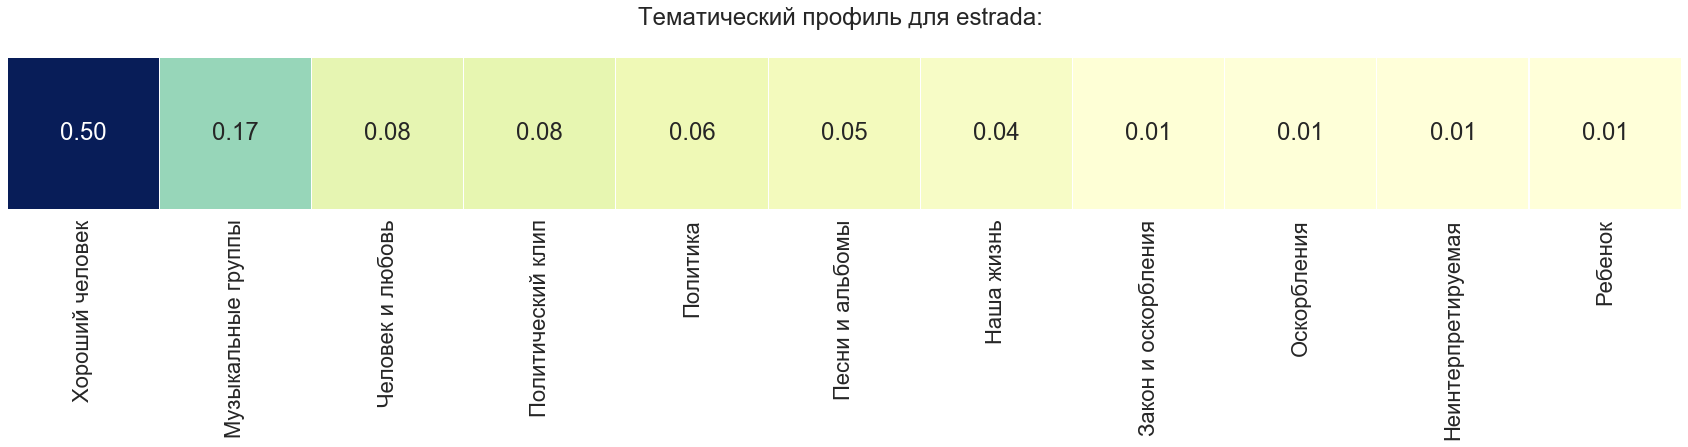

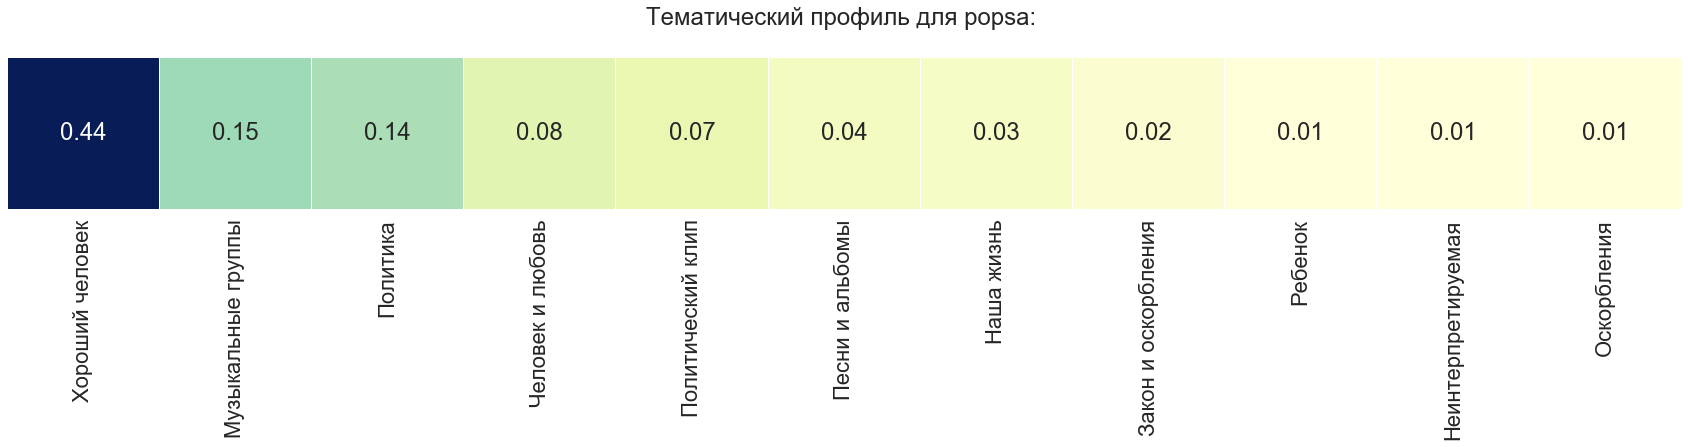

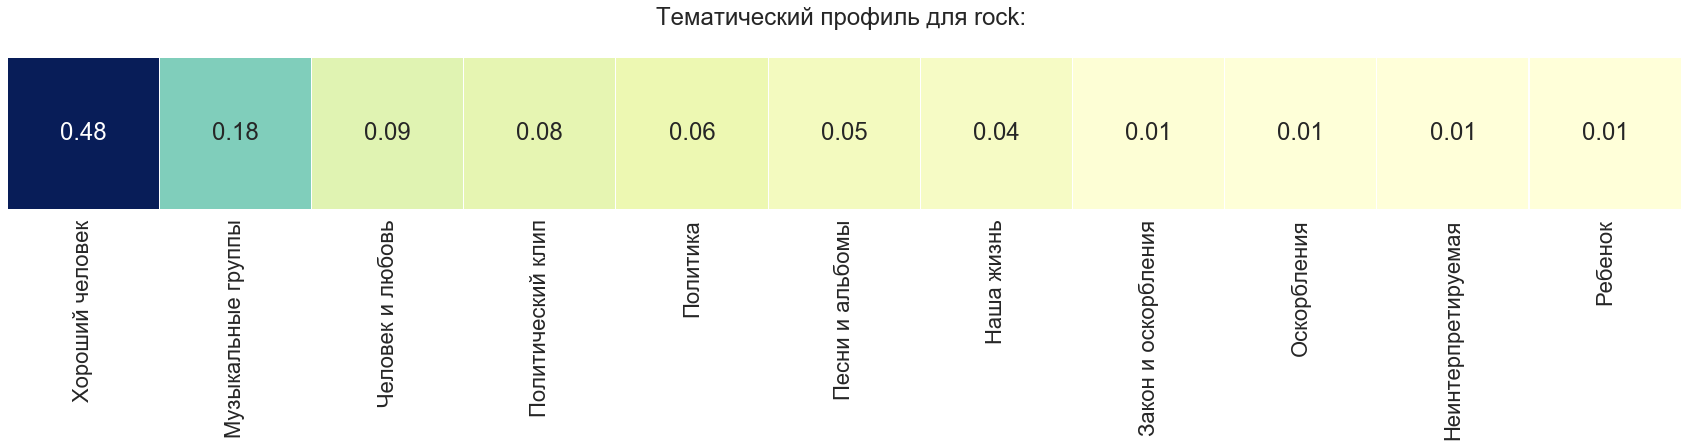

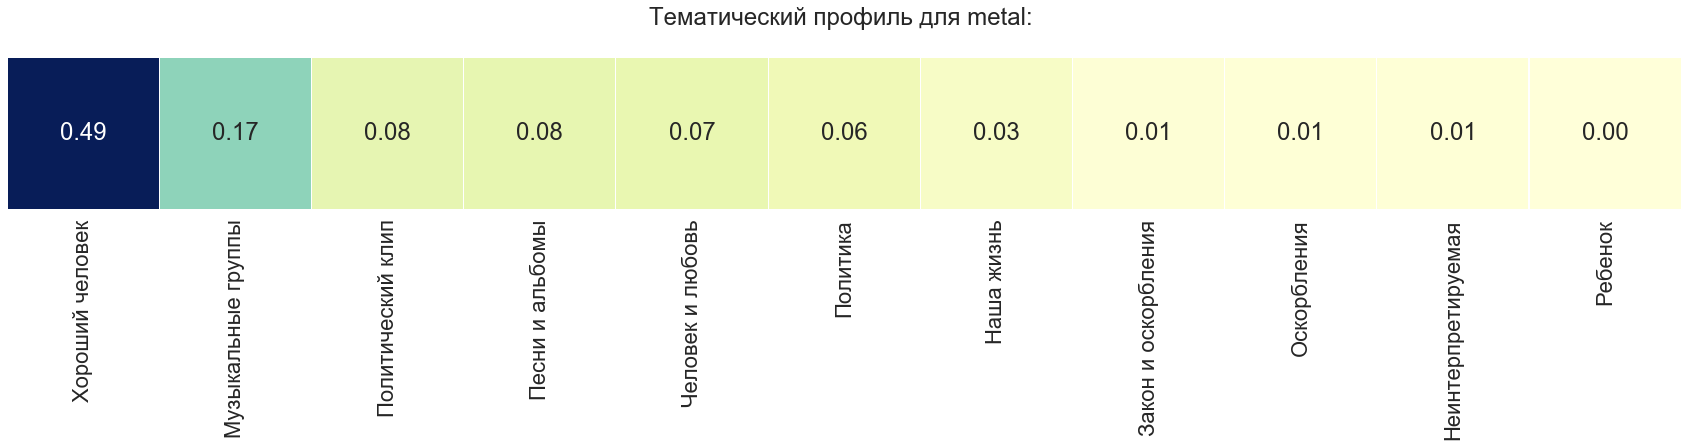

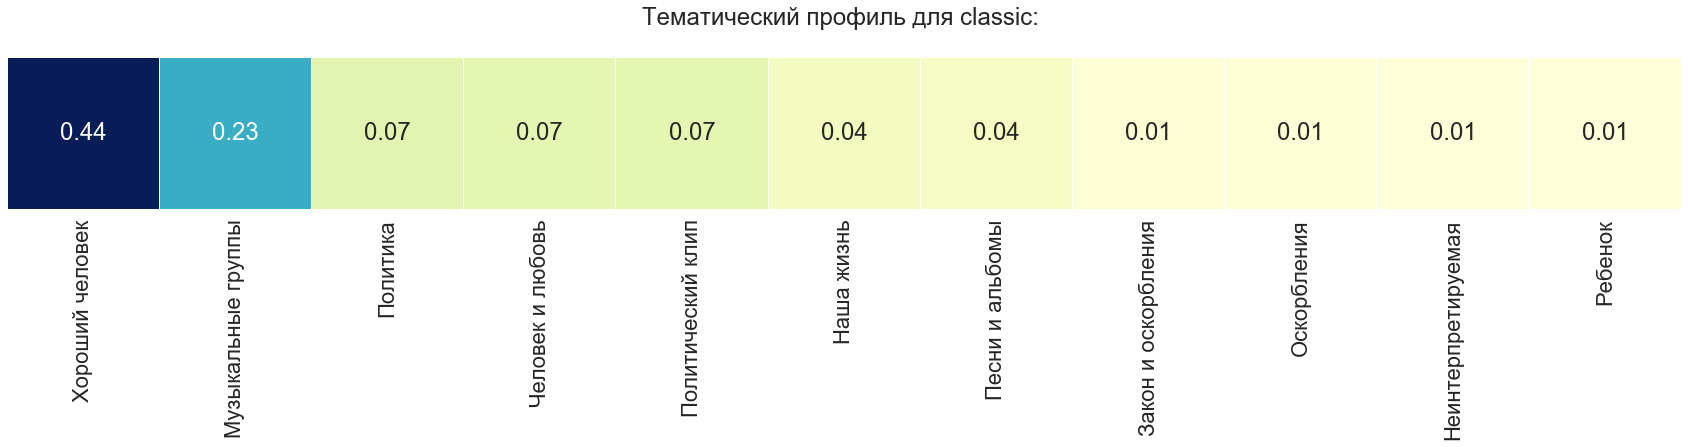

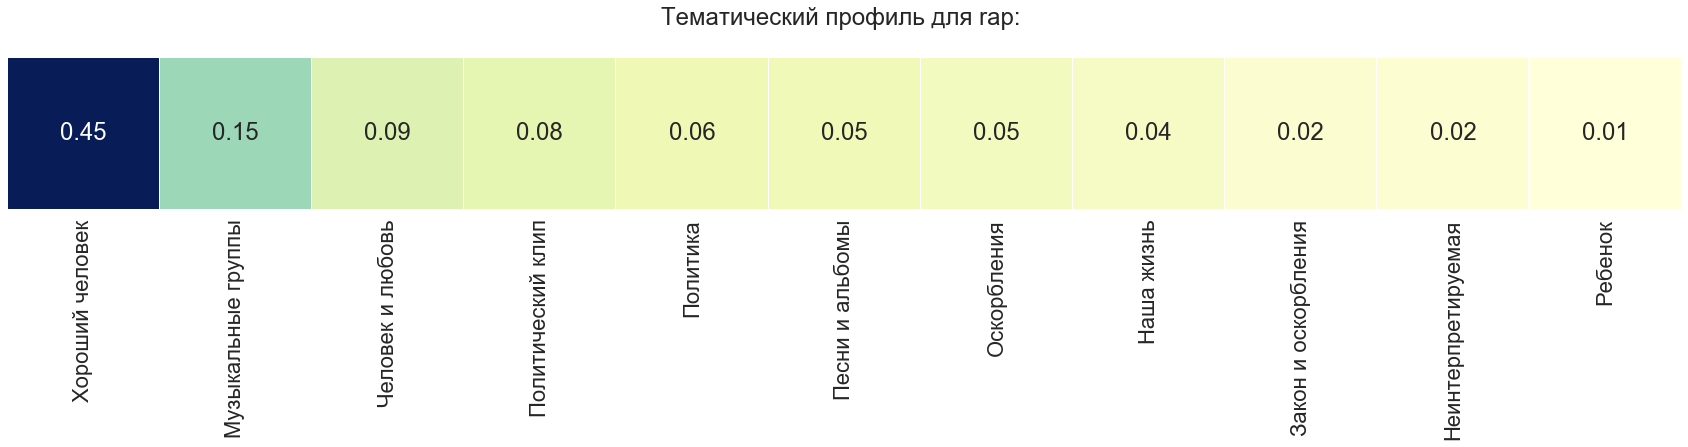

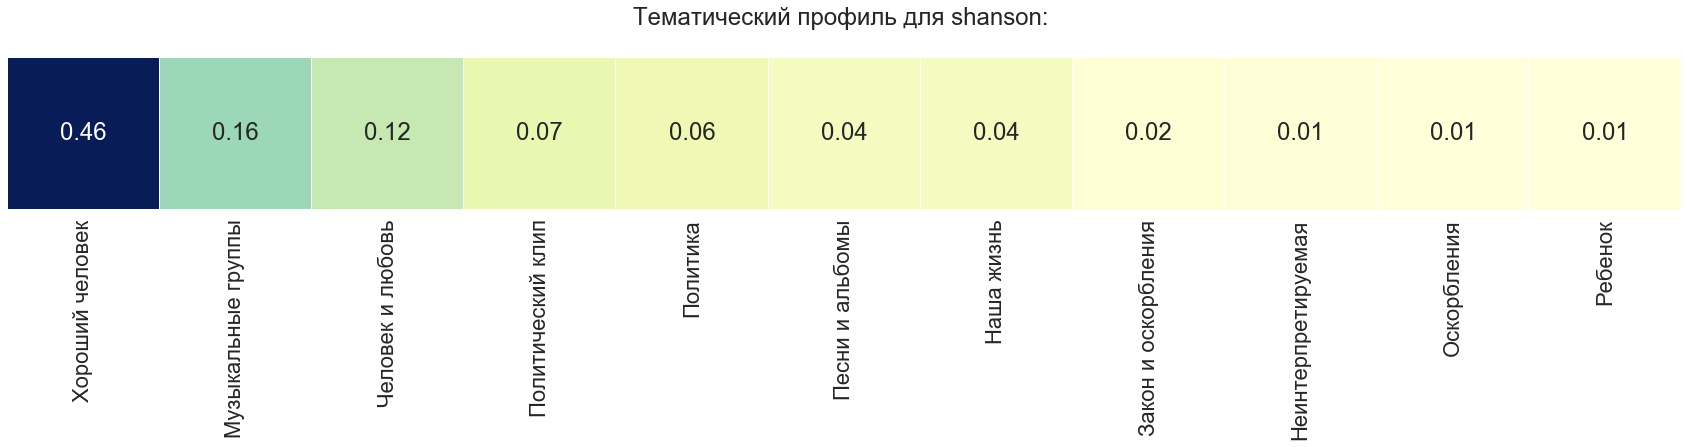

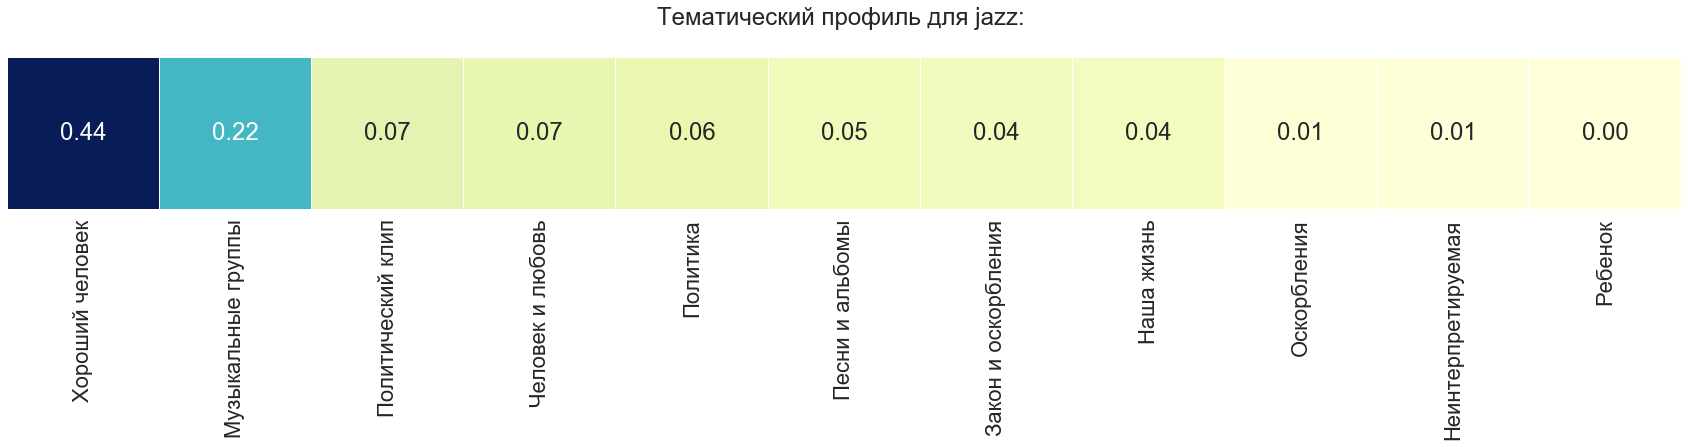

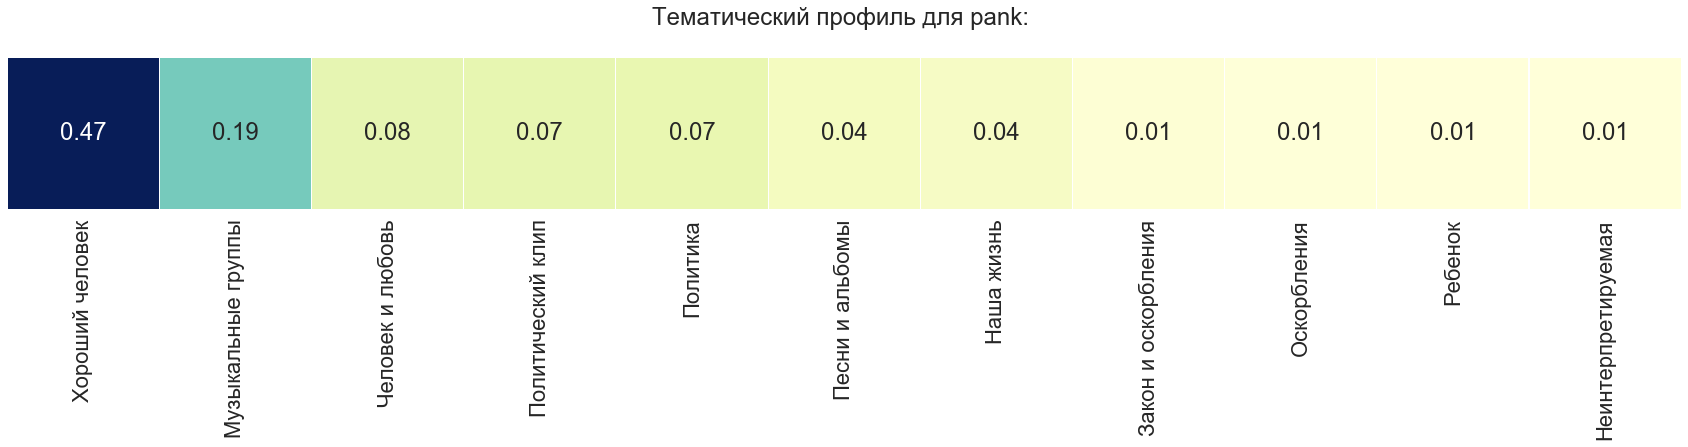

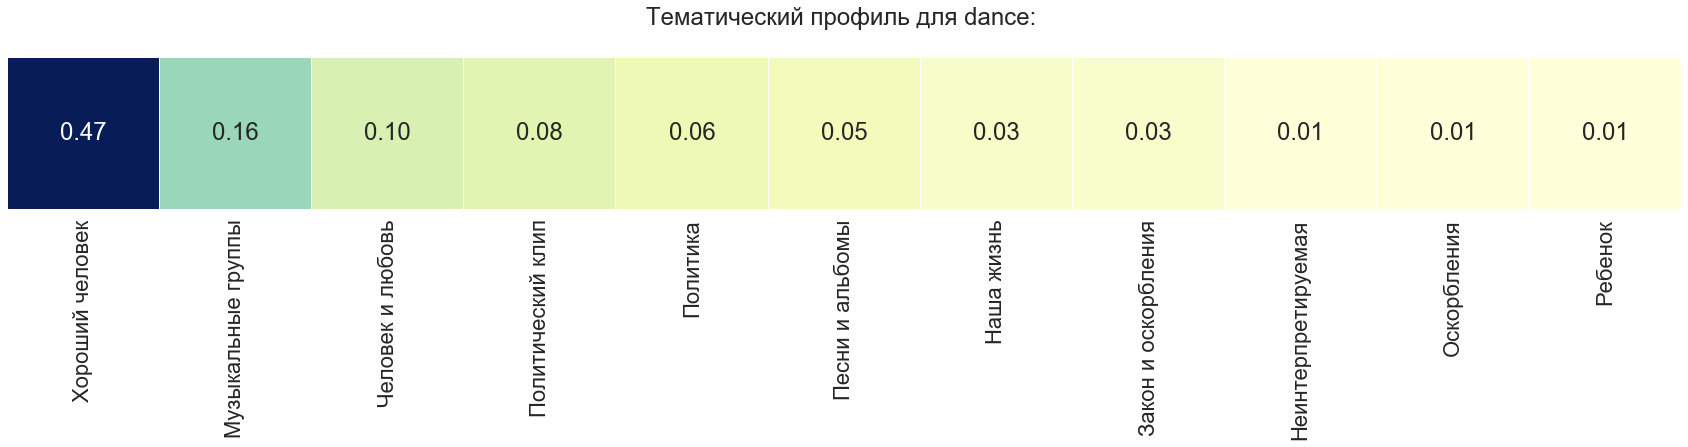

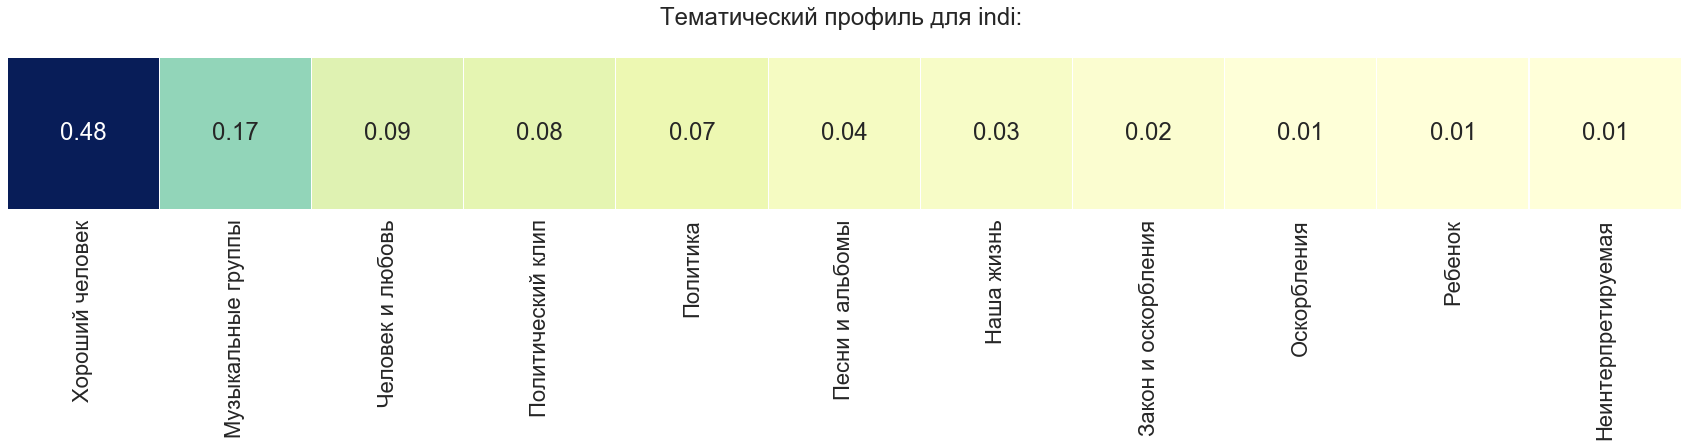

In [67]:
for music_style in df.music_style.unique():
    profilePlot(music_style_themes, music_style)

Построим по данным T_SNE.

In [48]:
%%time
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100572 samples in 0.156s...
[t-SNE] Computed neighbors for 100572 samples in 44.715s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100572
[t-SNE] Computed conditional probabilities for sample 2000 / 100572
[t-SNE] Computed conditional probabilities for sample 3000 / 100572
[t-SNE] Computed conditional probabilities for sample 4000 / 100572
[t-SNE] Computed conditional probabilities for sample 5000 / 100572
[t-SNE] Computed conditional probabilities for sample 6000 / 100572
[t-SNE] Computed conditional probabilities for sample 7000 / 100572
[t-SNE] Computed conditional probabilities for sample 8000 / 100572
[t-SNE] Computed conditional probabilities for sample 9000 / 100572
[t-SNE] Computed conditional probabilities for sample 10000 / 100572
[t-SNE] Computed conditional probabilities for sample 11000 / 100572
[t-SNE] Computed conditional probabilities for sample 12000 / 100572
[t-SNE] Computed conditional probab

In [49]:
# Plot the Topic Clusters using Bokeh
import matplotlib.colors as mcolors
output_notebook()
n_topics = 11
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)

plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])

show(plot);

Loading BokehJS ...

# Выводы

По датасету с коментариями из ВК:
1. Построена LDA-модель и определено оптимальное кол-во топиков
2. Показана визуализация wordcloud для топиков
3. Построена визуализация TSNE для тематических профилей